In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score

In [2]:
mobilenet_path = 'mobilenet_training_results\\mobilenet_test_preds.csv'
c3d_path = 'c3d_training_results\\c3d_test_preds.csv'
resnet_path = 'resnet50v2_training_results\\resnet50v2_test_preds.csv'

df_mobilenet = pd.read_csv(mobilenet_path)
df_c3d = pd.read_csv(c3d_path)
df_resnet = pd.read_csv(resnet_path)

In [3]:
def get_model_scores(df, model_name):
    
    models = set(df.columns[2:].str.replace('_fight|_fall',''))

    df_auc = pd.DataFrame()

    for model in models:
        fight_auc = roc_auc_score(df['is_fight'], df[model + '_fight'])
        fall_auc = roc_auc_score(df['is_falldown'], df[model + '_fall'])
        macro_auc = (fight_auc + fall_auc) / 2

        df_auc = df_auc\
            .append(pd.Series({'Fight AUC':fight_auc, 'Fall AUC':fall_auc, 'Macro AUC':macro_auc}, name=model))

    #df_auc = df_auc.reset_index().rename(columns={'index':'Image Type'})
    df_auc['Image Type'] = df_auc.index.str[:3].str.replace('_','').str.upper()
    df_auc['Model'] = model_name
    
    return df_auc

In [4]:
df_mobilenet_auc = get_model_scores(df_mobilenet, 'LRCN (MobileNet)')
df_resnet_auc = get_model_scores(df_resnet, 'LRCN (ResNet)')
df_c3d_auc = get_model_scores(df_c3d, '3DCNN')

In [5]:
df_combined = pd.concat([df_c3d_auc, df_resnet_auc, df_mobilenet_auc])

In [7]:
def plot_grouped_chart(df, hue, x, plot_func, 
                       hue_order=None, order=None, 
                       ylim=(0.4,1.), figsize=(16,9), layout='v', **plot_params):
    
    if hue_order == None:
        hue_order = sorted(df[hue].unique())
    
    if order == None:
        order = sorted(df[x].unique())
        
    alpha = 0.8
    
    if layout == 'h':
        n_row_cols = (1,2)
    else:
        n_row_cols = (2,1)
    
    f, (ax1, ax2) = plt.subplots(*n_row_cols, figsize=figsize)

    plot_func(x=x,y='Fight AUC', order=order, hue=hue, hue_order=hue_order, data=df, ax=ax1, **plot_params)
    ax1.set_title('Fight', fontsize=14)
    ax1.set_ylim(*ylim)
    ax1.legend([])
    ax1.set_xlabel(None)
    
    for patch in ax1.patches:
        patch.set_alpha(alpha)
        
    plot_func(x=x,y='Fall AUC', order=order, hue=hue, hue_order=hue_order, data=df, ax=ax2, **plot_params)
    ax2.set_title('Fall', fontsize=14)
    ax2.set_ylim(*ylim)
    ax2.set_xlabel(None)

    
    for patch in ax2.patches:
        patch.set_alpha(alpha)
    
    if hue != None:
        h, l = ax2.get_legend_handles_labels()

        ax2.legend([])
        f.legend(h, l, bbox_to_anchor=(1.02,0.5), loc='center left')
    
    plt.tight_layout()
    plt.show()

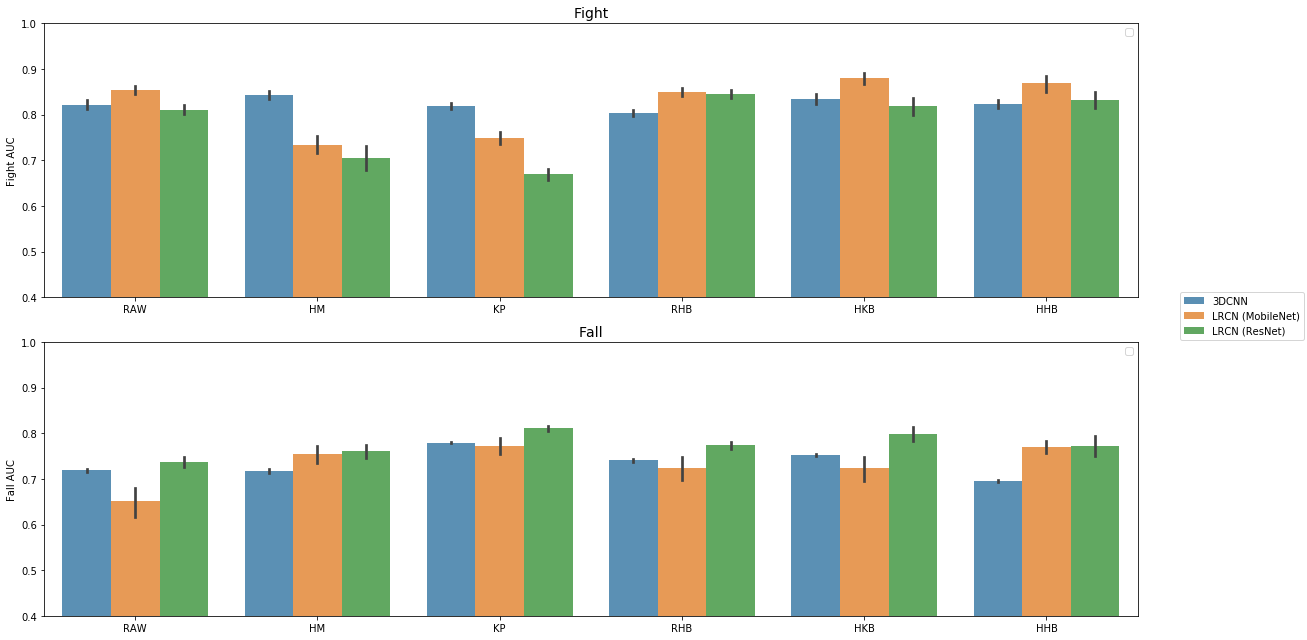

In [8]:
MODEL_ORDER = ['3DCNN', 'LRCN (MobileNet)', 'LRCN (ResNet)']
IMG_ORDER = ['RAW','HM','KP','RHB','HKB','HHB']

plot_grouped_chart(df_combined, 
                   hue='Model',
                   x='Image Type', 
                   plot_func=sns.barplot,
                   hue_order=MODEL_ORDER,
                   order=IMG_ORDER)

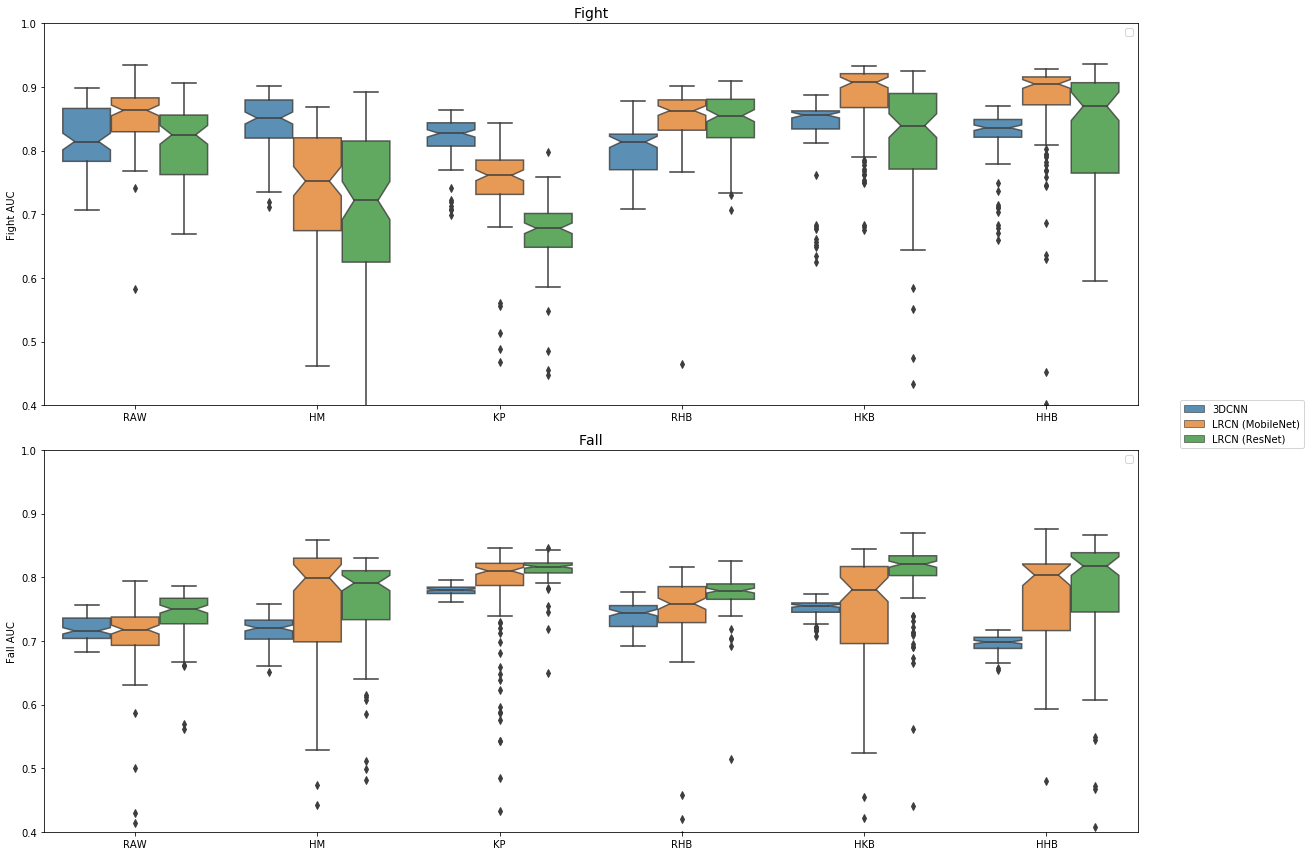

In [9]:
plot_grouped_chart(df_combined, 
                   hue='Model',
                   x='Image Type', 
                   plot_func=sns.boxplot,
                   hue_order=MODEL_ORDER,
                   order=IMG_ORDER, 
                   ylim=(0.4,1.), 
                   figsize=(16,12), 
                   boxprops=dict(alpha=.8), 
                   notch=True)

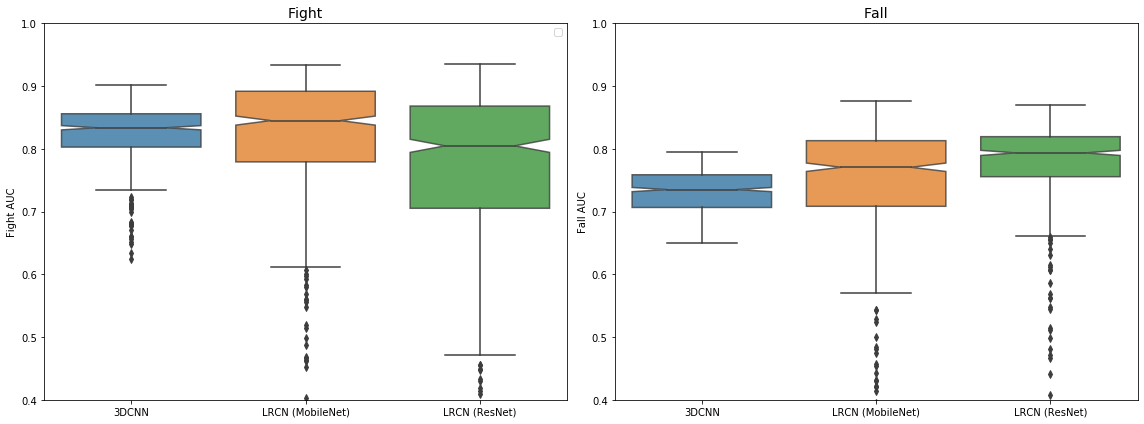

In [10]:
plot_grouped_chart(df_combined, 
                   hue=None, 
                   x='Model',
                   plot_func=sns.boxplot,
                   hue_order='',
                   order=MODEL_ORDER,
                   ylim=(0.4,1.), 
                   figsize=(16,6), 
                   layout='h',
                   boxprops=dict(alpha=.8), notch=True)

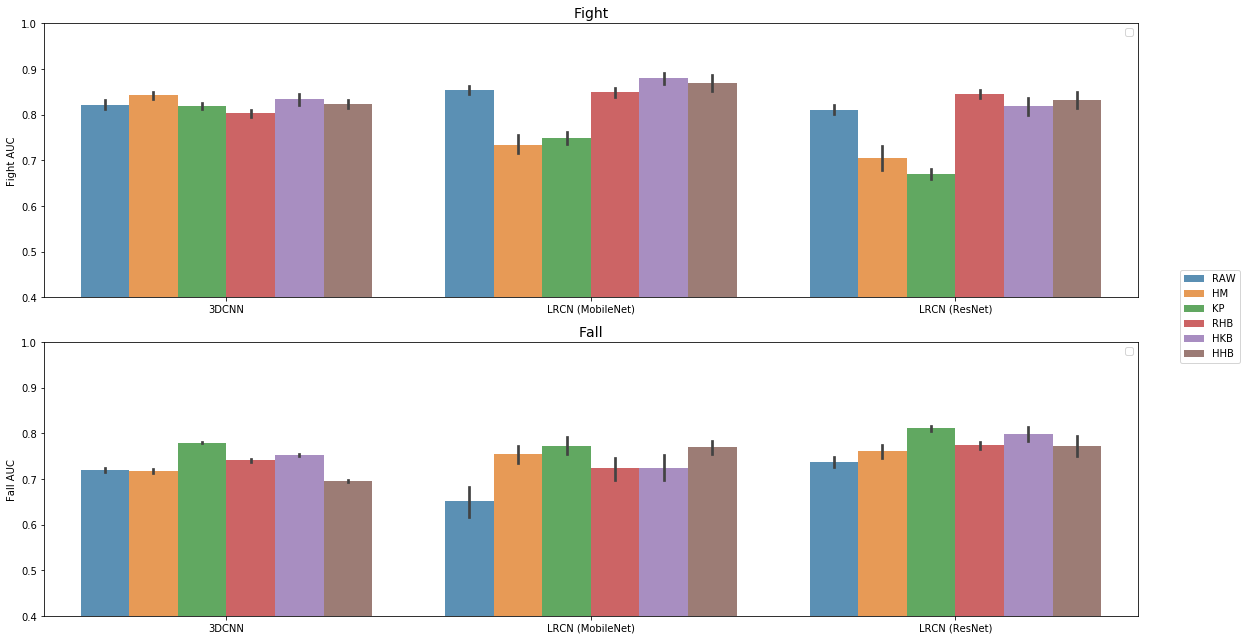

In [11]:
plot_grouped_chart(df_combined, 
                   hue='Image Type', 
                   x='Model',
                   plot_func=sns.barplot,
                   hue_order=IMG_ORDER,
                   order=MODEL_ORDER)

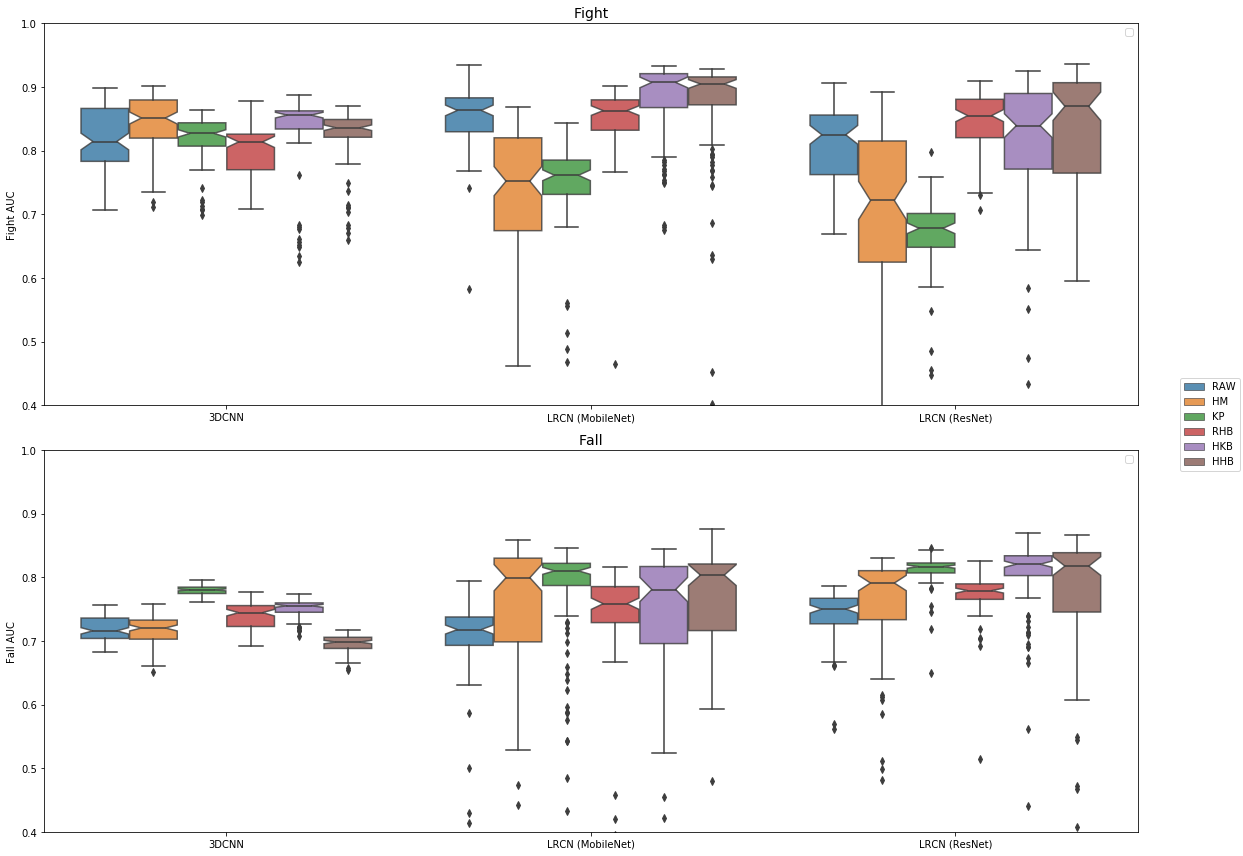

In [12]:
plot_grouped_chart(df_combined, 
                   hue='Image Type', 
                   x='Model',
                   plot_func=sns.boxplot,
                   hue_order=IMG_ORDER,
                   order=MODEL_ORDER,
                   ylim=(0.4,1.), 
                   figsize=(16,12), 
                   boxprops=dict(alpha=.8), 
                   notch=True)

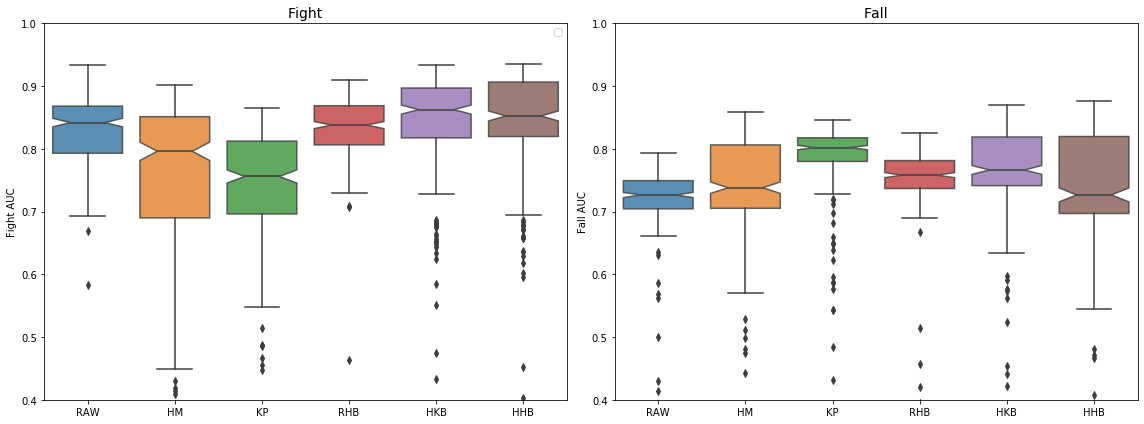

In [13]:
plot_grouped_chart(df_combined, 
                   hue=None, 
                   x='Image Type',
                   plot_func=sns.boxplot,
                   hue_order='',
                   order=IMG_ORDER,
                   ylim=(0.4,1.), 
                   figsize=(16,6), 
                   layout='h',
                   boxprops=dict(alpha=.8), notch=True)

In [14]:
def plot_histograms(df, target_class):

    plt.figure(figsize=(18,10))
    
    for index, img_type in enumerate(['RAW', 'HM', 'KP', 'RHB', 'HKB', 'HHB']):

        plt.subplot(2,3,index + 1)
        df\
            .loc[df['Image Type'] == img_type, [f'{target_class} AUC','Model']]\
            .groupby('Model')[f'{target_class} AUC']\
            .plot(kind='hist', alpha=0.3, bins=20)

        plt.xlim(0.2,1)
        plt.legend()
        plt.title(f'Image Type : {img_type}')

    plt.suptitle(f'{target_class} AUC Distributions', fontsize=16)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    plt.show()

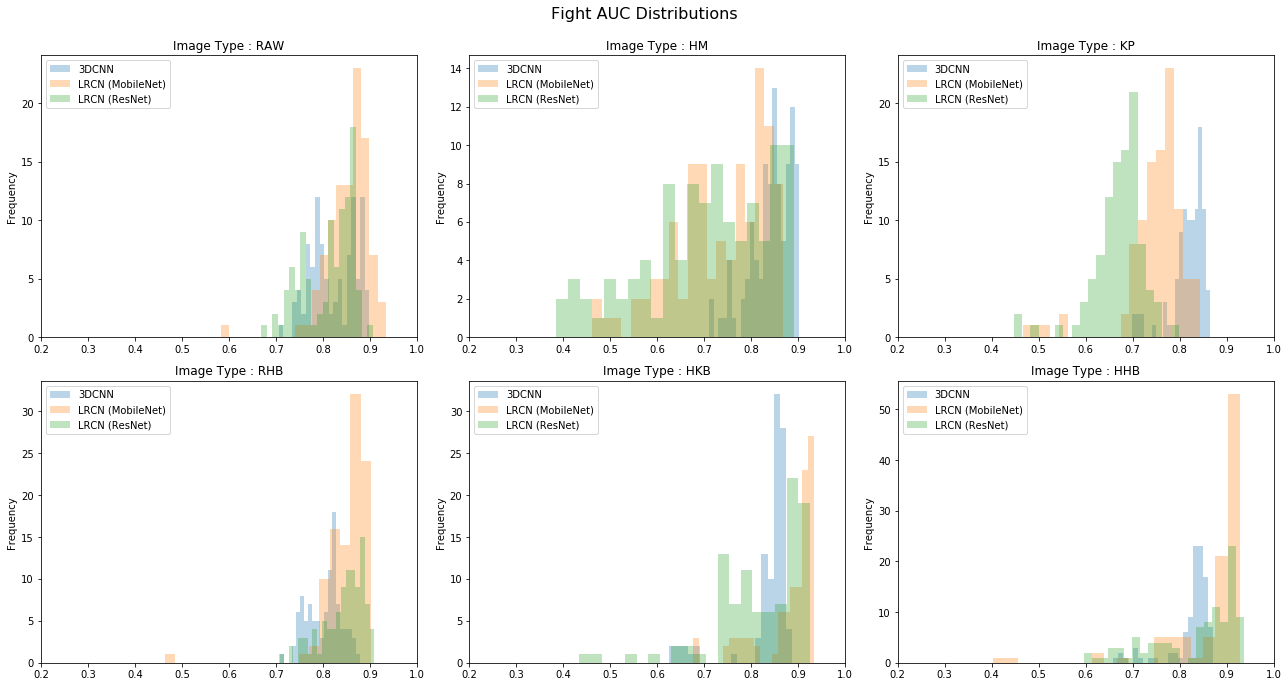

In [15]:
plot_histograms(df_combined, 'Fight')

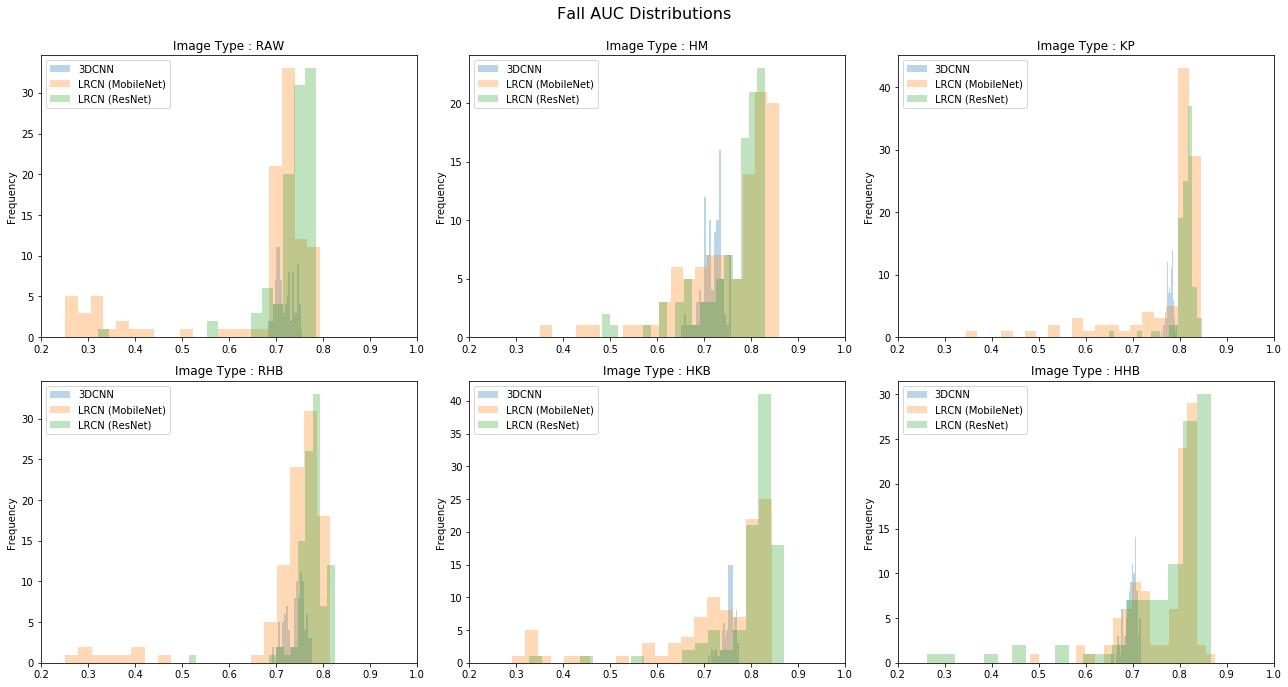

In [16]:
plot_histograms(df_combined, 'Fall')

In [17]:
summary_table = df_combined.groupby(['Model','Image Type'])\
    .agg(Fight_AUC_mean = ('Fight AUC','mean'),
         Fight_AUC_std = ('Fight AUC','std'),
         Fall_AUC_mean = ('Fall AUC','mean'),
         Fall_AUC_std = ('Fall AUC','std'),
         Macro_AUC_mean = ('Macro AUC','mean'),
         Macro_AUC_std = ('Macro AUC','std'))

In [18]:
summary_table[['Fight_AUC_mean','Fight_AUC_std']]\
    .sort_values(['Fight_AUC_mean','Fight_AUC_std'], ascending=[False,True])\
    .reset_index()\
    .iloc[0:3]

,Model,Image Type,Fight_AUC_mean,Fight_AUC_std
0,LRCN (MobileNet),HKB,0.879356,0.062064
1,LRCN (MobileNet),HHB,0.870201,0.088742
2,LRCN (MobileNet),RAW,0.853748,0.046252


In [19]:
summary_table[['Fall_AUC_mean','Fall_AUC_std']]\
    .sort_values(['Fall_AUC_mean','Fall_AUC_std'], ascending=[False,True])\
    .reset_index()\
    .iloc[0:3]

,Model,Image Type,Fall_AUC_mean,Fall_AUC_std
0,LRCN (ResNet),KP,0.811211,0.023942
1,LRCN (ResNet),HKB,0.799092,0.078300
2,3DCNN,KP,0.779688,0.006765


In [20]:
summary_table[['Macro_AUC_mean','Macro_AUC_std']]\
    .sort_values(['Macro_AUC_mean','Macro_AUC_std'], ascending=[False,True])\
    .reset_index()\
    .iloc[0:3]

,Model,Image Type,Macro_AUC_mean,Macro_AUC_std
0,LRCN (MobileNet),HHB,0.819566,0.050306
1,LRCN (ResNet),RHB,0.809735,0.029955
2,LRCN (ResNet),HKB,0.808836,0.051998
